In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

In [2]:
def stringify(arr):
    return "'" + "','".join(arr) + "'"

In [3]:
START_DATE = '2023-04-01'
END_DATE = '2025-03-01'

## Onchain Builders

In [4]:
df_onchain_projects = client.to_pandas(f"""
select
    p.project_id,
    p.project_name,
    p.display_name,
    pbc.collection_name
from oso.projects_v1 p
join oso.projects_by_collection_v1 pbc on p.project_id = pbc.project_id
where pbc.collection_name in ('op-rpgf3', '8-1')
order by p.display_name
""")
PROJECT_IDS = list(df_onchain_projects['project_id'].unique())
df_onchain_projects.set_index('project_id', inplace=True)

In [5]:
METRICS = [
    f"{c.upper()}_{m}"
    for c in [  # Supported chains
        'automata', 'cyber', 'ham', 
        'base', 'bob', 'frax', 'ink', 'kroma', 'lisk', 'lyra',
        'metal', 'mint', 'mode', 'optimism', 'orderly', 'polynomial',
        'race', 'redstone', 'shape', 'soneium', 'swan', 'swell',
        'unichain', 'worldchain', 'xterio', 'zora'
    ]
    for m in [  # Metric types
        'defillama_tvl_daily',
        'gas_fees_daily',     
        'contract_invocations_daily',
        'transactions_daily'
    ]
] + ['S7_M1_devtooling_reward', 'S7_M1_onchain_builder_reward']

In [6]:
df_onchain_metrics = client.to_pandas(f"""
select
    tm.project_id,
    p.project_name,
    p.display_name,
    tm.sample_date,
    m.display_name as metric_category,
    SUM(tm.amount) as amount
from oso.timeseries_metrics_by_project_v0 tm
join oso.metrics_v0 m on tm.metric_id = m.metric_id
join oso.projects_v1 p on tm.project_id = p.project_id
where    
    tm.sample_date >= DATE('{START_DATE}') AND tm.sample_date < DATE('{END_DATE}')    
    and tm.project_id IN ({stringify(PROJECT_IDS)})
    and m.metric_name IN ({stringify(METRICS)})
group by 1,2,3,4,5
""")
df_onchain_metrics.tail()

,project_id,project_name,display_name,sample_date,metric_category,amount
325582,i7+GWX1oIywd4Pd5yL9aZAFhBIjY40c48Yg4BXFKW9o=,0x8efcf1b6e879bb6ec89d5982b8da840757053731b897...,Bogdan,2024-12-14,Defillama TVL,5734573.68914
325583,D/phNjIkMkuESYi0XbICo299wHOagQbo2WSAyODxDp0=,0x62e37e96aa6e1cbfb6bd24b97c4b8f1e12cc3fe35d53...,Stargate Finance,2024-12-14,Defillama TVL,85490352.68789
325584,v9C8yfcPG3QTWruewgVAij9YK5/W6p+8H4kaTIllhjE=,sushi,Sushi,2024-12-14,Defillama TVL,35303911.10469
325585,23XIt7EgzQNc2AdcEzTg7GbjT5kKY1lNFfmcGQvrkWA=,0xefaeef1446de875ab6e50d31c8dbe776f99d884cb8cb...,Synapse Protocol,2024-12-14,Defillama TVL,3846449.92069
325586,a71tbYAPlOpIwh4+Y591PqZ/kYIbS4qRRpQ8WH2w4oM=,0x3526b9c6fdc34076d7d2c31893b94e760f4d5a010387...,Gyroscope,2024-12-14,Defillama TVL,2597205.33407


In [7]:
project_transactions = (
    df_onchain_metrics
    .query("metric_category == 'Contract Invocations'")
    .groupby('project_name', as_index=False)
    ['amount'].sum()
    .rename(columns={'amount': 'transactions'})
    .set_index('project_name')
)

In [8]:
df_funding = pd.read_csv("../../../../../Github/oss-funding/data/funding_data.csv")
df_funding_rf3 = df_funding[df_funding['grant_pool_name'] == 'retropgf3']
df_funding_rf3 = df_funding_rf3[['to_project_name', 'amount']]
df_funding_rf3.dropna(inplace=True)
df_funding_rf3.set_index('to_project_name', inplace=True)
df_funding_rf3.rename(columns={'amount': 'funding'},inplace=True)
df_funding_rf3['funding'] = df_funding_rf3['funding'] / 3.5

In [9]:
df_funding_s7 = (
    df_onchain_metrics[df_onchain_metrics['metric_category'].str.contains('M1')==True]
    .groupby('project_name')['amount']
    .sum()
    .reset_index()
    .rename(columns={'amount': 'funding'})
    .set_index('project_name')
)

/var/folders/gh/1v87rt9j01gcjctn3v95bqkw0000gn/T/ipykernel_81431/262480469.py:6: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query("transactions >= 1000 and funding > 0")
/var/folders/gh/1v87rt9j01gcjctn3v95bqkw0000gn/T/ipykernel_81431/262480469.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,)


(0.0, 300000.0)

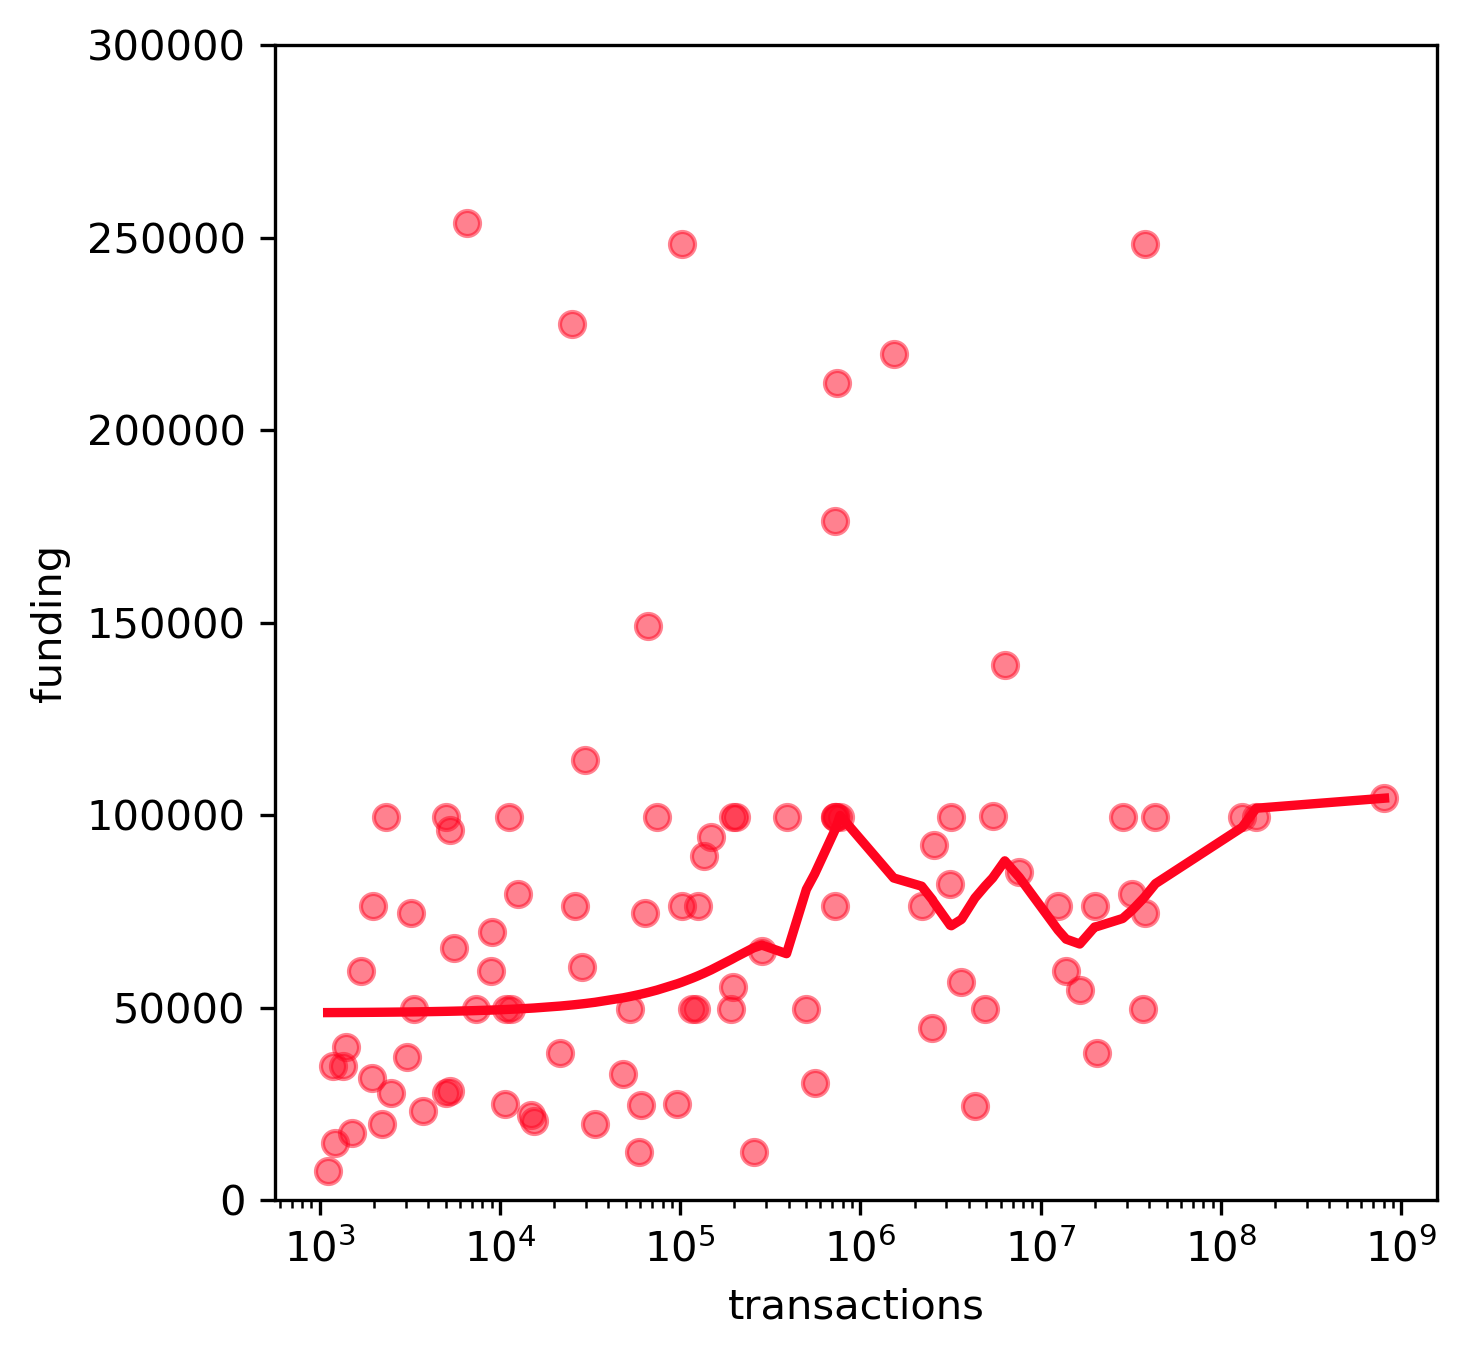

In [10]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
sns.regplot(
    data=(
        project_transactions
        .join(df_funding_rf3)
        .query("transactions >= 1000 and funding > 0")
    ),
    x='transactions',
    y='funding',
    color='#ff0420',
    lowess=True,
    scatter_kws={'color': '#ff0420', 'alpha': 0.5},
    ax=ax
)

ax.set_xscale('log')
ax.set_xlim(0,)
ax.set_ylim(0,300_000)

/var/folders/gh/1v87rt9j01gcjctn3v95bqkw0000gn/T/ipykernel_81431/4114515615.py:6: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query("transactions >= 1000 and funding > 0")
/var/folders/gh/1v87rt9j01gcjctn3v95bqkw0000gn/T/ipykernel_81431/4114515615.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,)


(0.0, 70000.0)

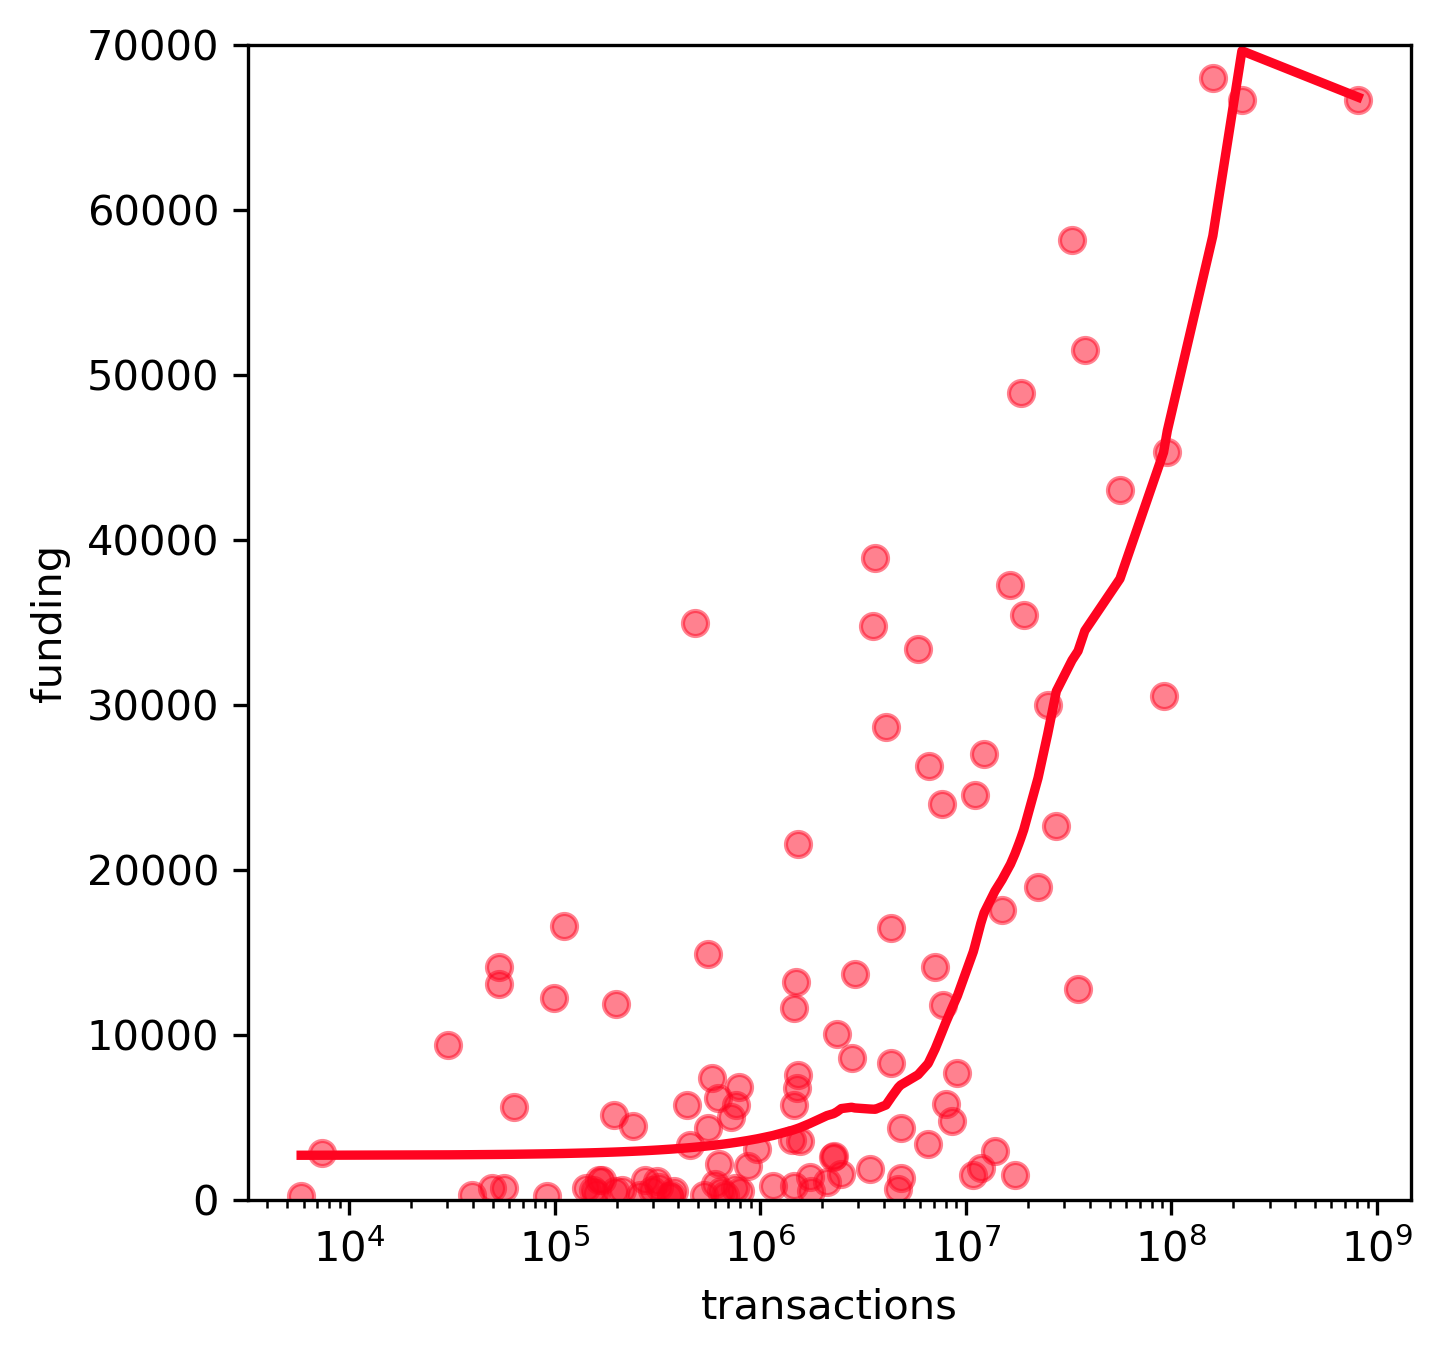

In [11]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
sns.regplot(
    data=(
        project_transactions
        .join(df_funding_s7)
        .query("transactions >= 1000 and funding > 0")
    ),
    x='transactions',
    y='funding',
    color='#ff0420',
    lowess=True,
    scatter_kws={'color': '#ff0420', 'alpha': 0.5},
    ax=ax
)

ax.set_xscale('log')
ax.set_xlim(0,)
ax.set_ylim(0,70_000)